In [1]:
# IMPORT THE LIBRARY
!pip install yfinance


In [2]:
!pip install ipynb

In [143]:
SENTIMENT_ANALYSIS = 0
if SENTIMENT_ANALYSIS:
    !pip install newspaper3k
    !pip install GoogleNews
    !pip install nltk
    !pip install newspaper
    !pip install wordcloud
else:
    print("Sentiment analysis disabled")

Sentiment analysis disabled


In [144]:
from datetime import datetime
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
if SENTIMENT_ANALYSIS:
    import nltk
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    from GoogleNews import GoogleNews
    from newspaper import Article
    from newspaper import Config
    from wordcloud import WordCloud, STOPWORDS
    import json
    nltk.download('vader_lexicon') #required for Sentiment Analysis
    nltk.download('punkt')
else:
    print("Sentiment analysis disabled")

Sentiment analysis disabled


In [145]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import SparkSession
from pyspark.sql import functions as sqlFn
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
#from ipynb.fs.full.SentimentAnalysis import GenerateCSVFile
from SentLib import GenerateCSVFile

In [146]:
# CREATE TICKER INSTANCE FOR AMAZON
amzn = yf.Ticker("AMZN")

# GET TODAYS DATE AND CONVERT IT TO A STRING WITH YYYY-MM-DD FORMAT (YFINANCE EXPECTS THAT FORMAT)
end_date = datetime.now().strftime('%Y-%m-%d')
if SENTIMENT_ANALYSIS:
    amzn_hist = amzn.history(start='2024-03-01',end='2024-04-01')
else:
    amzn_hist = amzn.history(start='2010-01-16',end='2024-04-16')
#print(amzn_hist)
amzn_hist.to_csv('amazon.csv')

In [147]:
#Generate Sentiment Analysis CSV file for Amazon with normalized sentiment of '1' or '0'
if SENTIMENT_ANALYSIS:
    GenerateCSVFile("AMZN",'sentiment_data.csv',31)
else:
    print("Sentiment analysis disabled")

Sentiment analysis disabled


In [148]:
# Create a Spark session
spark = SparkSession.builder.appName("StockPredictionModel").getOrCreate()
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
if SENTIMENT_ANALYSIS:
    # Load the data from the CSV into a DataFrame
    df1 = spark.read.csv("amazon.csv", header=True, inferSchema=True)
else:
    df = spark.read.csv("amazon.csv", header=True, inferSchema=True)
    df1 = df
    print("Sentiment analysis disabled")
    


Sentiment analysis disabled


In [149]:
df1.show(8)

+--------------------+------------------+-----------------+------------------+-----------------+---------+---------+------------+
|                Date|              Open|             High|               Low|            Close|   Volume|Dividends|Stock Splits|
+--------------------+------------------+-----------------+------------------+-----------------+---------+---------+------------+
|2010-01-19 00:00:...| 6.315499782562256|6.400000095367432|6.2164998054504395|6.380499839782715|177852000|      0.0|         0.0|
|2010-01-20 00:00:...| 6.356500148773193|6.460000038146973| 6.254000186920166|6.289000034332275|181494000|      0.0|         0.0|
|2010-01-21 00:00:...|  6.36299991607666| 6.40749979019165|              6.25|6.330999851226807|199412000|      0.0|         0.0|
|2010-01-22 00:00:...|  6.28000020980835|6.383500099182129| 6.038000106811523|6.071499824523926|231378000|      0.0|         0.0|
|2010-01-25 00:00:...| 6.105000019073486|6.113999843597412| 5.906000137329102|6.0155000686

In [150]:
if SENTIMENT_ANALYSIS:
    df2 = spark.read.csv("sentiment_data.csv", header=True, inferSchema=True)
    df2.show(8)
    df = df1.join(df2, df1["Date"] == df2["Date"], "inner")
    df.show(8)
    #drop the extra "date"
    df = df.drop(df2["Date"])
    df.show(8)
else:
    print("Sentiment analysis disabled")

Sentiment analysis disabled


In [151]:
# drop any row having any Null 
df = df.dropna(how="any")

In [152]:
# openCloseChange
df = df.withColumn("openCloseChange", (df.Close - df.Open) / df.Open)



In [153]:
# maxDayChange
df = df.withColumn("maxDayChange", df.High - df.Low)



In [154]:
# dividend provided
df = df.withColumn("dividend", sqlFn.when(df["Dividends"] > 0, 1).otherwise(0))

In [155]:
# Stock split
df = df.withColumn("stockSplit", sqlFn.when(df["Stock Splits"] != 1, 1).otherwise(0))

In [156]:
# order by date 
w = Window.partitionBy().orderBy("date")

In [157]:
# Lagged column for the 'close' price (i.e., previous day's close)
df = df.withColumn("lagClose", sqlFn.lag(df.Close).over(w))

In [158]:
#  DailyChange - change in closing price from the previous day
df = df.withColumn("DailyChange", df.Close - df.lagClose)

In [159]:
# moving average for the closing prices
df = df.withColumn("movingAvgClose", sqlFn.avg(df.Close).over(w.rowsBetween(-6, 0)))



In [160]:
# drop any row having any Null 
df = df.dropna(how="any")



In [161]:
if SENTIMENT_ANALYSIS:
    consolidatedFeature = ["Open", "High", "Low", "Close", "Volume", "openCloseChange", 
                   "maxDayChange", "DailyChange", "movingAvgClose", 
                   "dividend", "stockSplit", "Sentiment"]
else:
    consolidatedFeature = ["Open", "High", "Low", "Close", "Volume", "openCloseChange", 
                   "maxDayChange", "DailyChange", "movingAvgClose", 
                   "dividend", "stockSplit"]
    print("Sentiment analysis disabled")

Sentiment analysis disabled


In [162]:
#store features in the vector column
assembler = VectorAssembler(inputCols=consolidatedFeature, outputCol="features")
df_assembled = assembler.transform(df)



In [178]:
# Split the data into a training set - 80% , 20% test set. 

trainingDataCount = int(df_assembled.count() * 0.8)
trainingData = df_assembled.orderBy("date").limit(trainingDataCount)
testData = df_assembled.subtract(trainingData)



In [210]:
# GBT Model Training
gbt = GBTRegressor(labelCol="Close", featuresCol="features", maxIter=20, maxBins =32, maxDepth =5,stepSize =0.10)


In [211]:
model = gbt.fit(trainingData)


In [212]:
predictions = model.transform(testData)



In [213]:
# Model Evaluation
# Compute the RMSE (Root Mean Squared Error) for the predictions
evaluator_rmse = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse")


In [214]:
rmse = evaluator_rmse.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data =", rmse)



Root Mean Squared Error (RMSE) on test data = 9.824598177963328


In [215]:
# Mean Absolute Error (MAE) and R-squared (R2)
for metric in ["mae", "r2"]:
    evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName=metric)
    value = evaluator.evaluate(predictions)
    print(f"{metric.upper()}: {value}")



MAE: 7.313947290801276
R2: 0.8821503702744099


In [185]:
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [186]:
preds = predictions.select("Date", "Close", "prediction").toPandas()

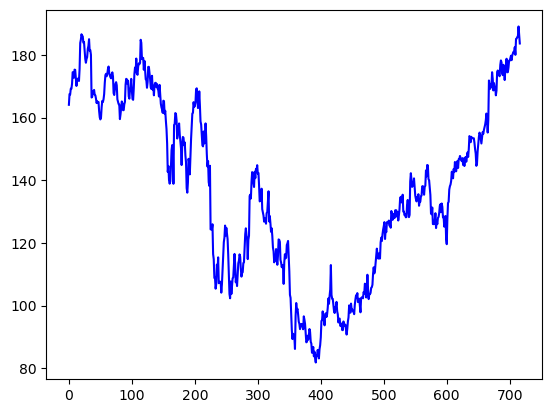

In [187]:
plt.plot(preds["Close"], label='Actual', color='blue')

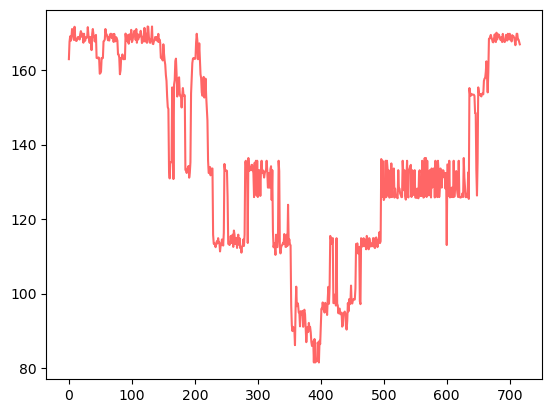

In [188]:
plt.plot(preds["prediction"], label='Predicted', color='red', alpha=0.6)

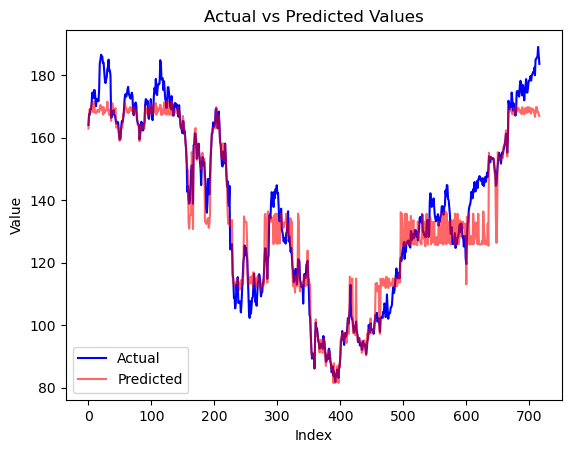

In [189]:
plt.plot(preds.index, preds["Close"], label='Actual', color='blue')
plt.plot(preds.index, preds["prediction"], label='Predicted', color='red', alpha=0.6)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

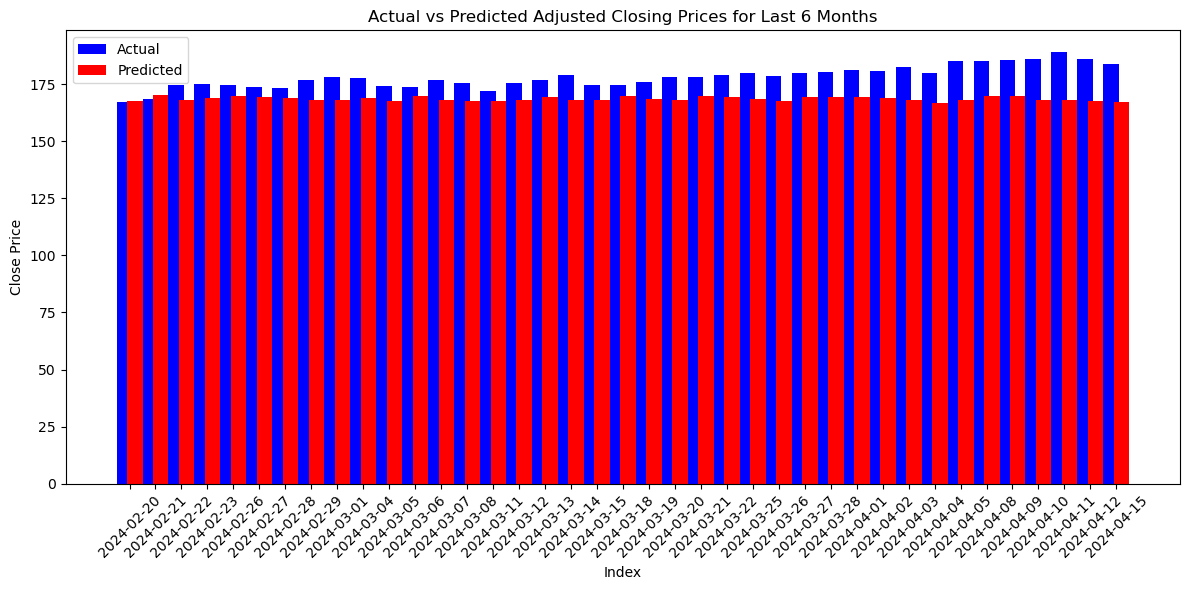

In [190]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt

# Convert "Date" column to datetime type, with utc=True
preds['Date'] = pd.to_datetime(preds['Date'], utc=True)

# Filter data for the Last 2 months
six_months_ago = pd.Timestamp.now(tz='UTC') - timedelta(days=30*2)
preds_last_6_months = preds[preds['Date'] >= six_months_ago]

# Creating the plot
plt.figure(figsize=(12, 6))  # Setting the figure size

# Plotting actual values as blue bars
plt.bar(preds_last_6_months.index, preds_last_6_months["Close"], color='blue', width=0.6, label='Actual')

# Shifting the position of predicted values slightly to the right for better visualization
plt.bar(preds_last_6_months.index + 0.4, preds_last_6_months["prediction"], color='red', width=0.6, label='Predicted')

plt.xlabel('Index')  # Labeling x-axis
plt.ylabel('Close Price')  # Labeling y-axis
plt.title('Actual vs Predicted Adjusted Closing Prices for Last 6 Months')  # Setting the title of the plot
plt.legend()  # Showing the legend
plt.xticks(preds_last_6_months.index + 0.2, preds_last_6_months['Date'].dt.strftime('%Y-%m-%d'))  # Setting x-axis ticks with dates
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjusting layout for better visualization
plt.show()  # Displaying the plot



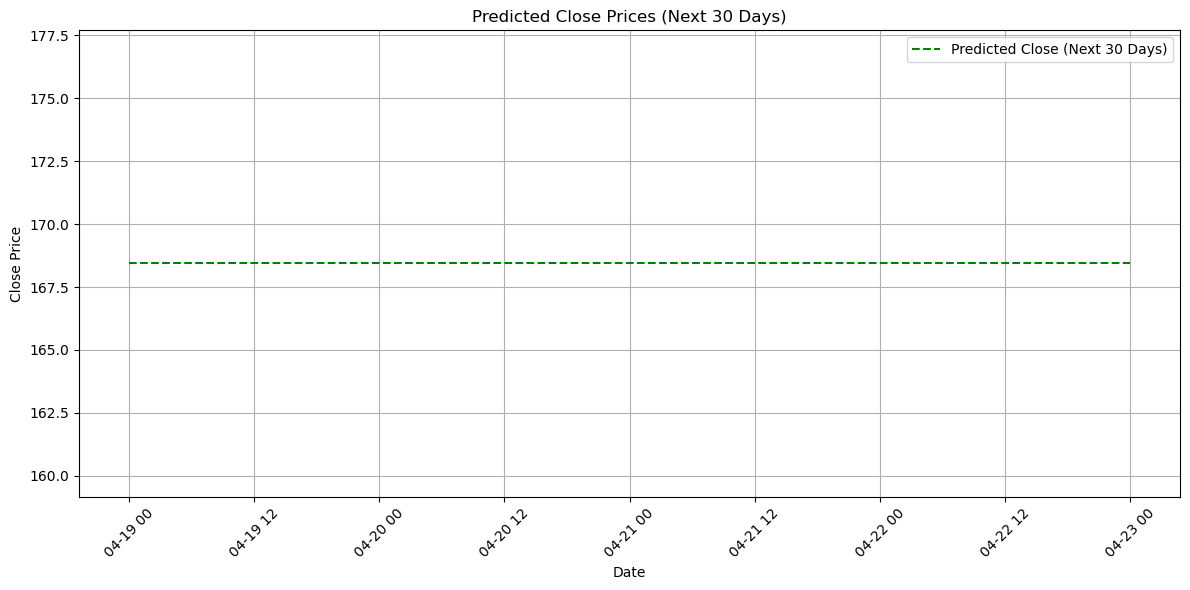

In [191]:
from matplotlib.dates import AutoDateLocator, AutoDateFormatter

# Prepare historical data for the past 1 month
end_date_past = datetime.now().strftime('%Y-%m-%d')
start_date_past = (datetime.now() - timedelta(days=30)).strftime('%Y-%m-%d')
past_data = df.filter((sqlFn.col("Date") >= start_date_past) & (sqlFn.col("Date") <= end_date_past))

# Apply the same feature engineering steps to past_data
# Assuming you've defined the feature_columns as before
consolidatedFeature = ["Open", "High", "Low", "Close", "Volume", "openCloseChange", 
                   "maxDayChange", "DailyChange", "movingAvgClose", 
                   "dividend", "stockSplit"]

# Assemble features
assembler = VectorAssembler(inputCols=consolidatedFeature, outputCol="features")
past_data_assembled = assembler.transform(past_data)

# Apply the trained model to make predictions for the past 1 month
past_predictions = model.transform(past_data_assembled)

# Plot the historical and predicted data for the past 1 month
past_data_pd = past_data.select("Date", "Close").toPandas()
past_pred_pd = past_predictions.select("Date", "prediction").toPandas()

last_date = datetime.strptime(end_date_past, '%Y-%m-%d')

# Prepare future data for the next 7 days using the last available data point
end_date_future = (datetime.now() + timedelta(days=30)).strftime('%Y-%m-%d')
future_dates = [last_date + timedelta(days=i) for i in range(1, 7)]  # Include next 7 days
future_df = spark.createDataFrame([(d,) for d in future_dates], ["Date"])
last_data_point = df.orderBy("Date", ascending=False).limit(1)  # Get the last available data point
future_df = future_df.crossJoin(last_data_point.drop("Date"))

# Apply the same feature engineering steps to future_df
future_df = future_df.withColumn("lagClose", sqlFn.lag(future_df.Close).over(Window.orderBy("Date")))
future_df = future_df.withColumn("dayChange", (future_df.Close - future_df.Open) / future_df.Open)
future_df = future_df.withColumn("maxDayChange", future_df.High - future_df.Low)
future_df = future_df.withColumn("DailyChange", future_df.Close - future_df.lagClose)
future_df = future_df.withColumn("movingAvgClose", sqlFn.avg(future_df.Close).over(Window.rowsBetween(-6, 0)))
future_df = future_df.withColumn("dividend", sqlFn.when(future_df["Dividends"] > 0, 1).otherwise(0))
future_df = future_df.withColumn("stockSplit", sqlFn.when(future_df["Stock Splits"] != 1, 1).otherwise(0))
future_df = future_df.dropna()
future_df_assembled = assembler.transform(future_df)

# Apply the trained model to make predictions for the next 7 days
future_predictions = model.transform(future_df_assembled)

# Plot the predicted data for the next 7 days
future_pred_pd = future_predictions.select("Date", "prediction").toPandas()

# Convert date column to pandas datetime object
future_pred_pd["Date"] = pd.to_datetime(future_pred_pd["Date"])

# Plot the predicted data for the next 7 days
plt.figure(figsize=(12, 6))
plt.plot(future_pred_pd["Date"], future_pred_pd["prediction"], label='Predicted Close (Next 30 Days)', color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Predicted Close Prices (Next 30 Days)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [432]:

# Terminate the Spark session
spark.stop()